tmp# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
Write the name (first and last) of the people on your team that are responsible for developing this solution.

 - Joana Morgado
 - Paulo Maia
 - Tiago Gonçalves
 - Tomé Albuquerque

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

 - [get_nr_pois_per_sensor.ipynb](https://link-url-here.org): This file is used to generate the points of interest per localisation
 - [plot_complaints_month_region.ipynb](https://link-url-here.org): This file is used to generate the plot that shows the number of complaints per month in the localisations
 - [clean_weather_data.ipynb](https://link-url-here.org): This file is used to apply a pre-processing to the weather data provided for this challenge
 - [thresh_df_0.5.csv](https://link-url-here.org): This file contains a dataframe with a boolean mapping of the places that are nearby our sensors given the threshold of 500 meters
 - [acustica_config.json](https://webgis.arpa.piemonte.it/Geoviewer2D/?config=other-configs/acustica_config.json): This file contains a mapping of the locations to their correspondent area type

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

#### TODO

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1]:
# General Imports
import random
import warnings
import os
import glob
import math
import numpy as np
import pandas as pd
import pickle

# Or if needed (Python version < 3.8)
# !pip install pickle5
import pickle5 as pickle


# Plots and Maps Packages
import folium
import matplotlib.pyplot as plt
import pylab
import seaborn as sns


# Machine Learning Packages (XGBoost, Sklearn and SHAP)
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score


# Time/Date Packages
from datetime import timedelta
import holidays



# Define random seeds
random.seed(42)
np.random.seed(42)

# Disable warnings to have a clean output
warnings.filterwarnings('ignore')

In [2]:
# Helper Functions
# Function: Get the energetic average of levels in decibels (such as audio)
def dbmean(levels, axis=None):
    """
    Energetic average of levels in decibels (such as audio).
    :param levels: Sequence of levels.
    :param axis: Axis over which to perform the operation.
    .. math:: L_{mean} = 10 \\log_{10}{\\frac{1}{n}\\sum_{i=0}^n{10^{L/10}}}
    """
    return 10.0 * np.log10((10.0**(levels / 10.0)).mean(axis=axis))

# Variable: Get the holidays in Italy
it_holidays = holidays.CountryHoliday('Italy')

## Data Loading

Loads:
- the list of sensors (from 2016 to 2019
- Acoustic zone mapping  for each sensor (dB limit in day and night)
- Businesses within 500 m radius
- Complaints data, which then filtered out to San Salvario, in the locations where we have sensors

In [3]:
# Load sensor list

sensor_list = pd.read_csv('data/noise_sensor_list.csv', sep = ';')
sensor_list['Sensor_ID'] = ['C1', 'C2', 'C3', 'C4', 'C5']
sensor_list['Lat'] = sensor_list['Lat'].str.replace(',', '.').astype(float)
sensor_list['Long'] = sensor_list['Long'].str.replace(',', '.').astype(float)

# Get mapping locations and correspondence to area type
# Link: https://webgis.arpa.piemonte.it/Geoviewer2D/?config=other-configs/acustica_config.json

mapping_location_area_code = pd.DataFrame(
    [['s_01', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_02', 60, 50, 'III - Aree di tipo misto'],
    ['s_03', 60, 50, 'III - Aree di tipo misto'],
    ['s_05', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_06', 60, 50, 'III - Aree di tipo misto']],
    columns=['code', 'day_max_db', 'night_max_db', 'area_type']
)

sensor_list = sensor_list.merge(mapping_location_area_code, on=['code'])

# Load businesses within 500 m radius
businesses_within_500m_radius = pd.read_csv('data/pois_per_sensor/thresh_df_0.5.csv', sep=';')
sensor_list = sensor_list.merge(businesses_within_500m_radius, on=['Sensor_ID'])

In [4]:
# Show this dataframe
businesses_within_500m_radius

,Sensor_ID,Abbigliamento,Alimentari,Alimentari annessi ad altra attivita,Articoli per animali,Articoli pr la casa,Articoli sanitari e ortopedici,Audiovisivi,Autoveicoli e motoveicoli,Bibite,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,C1,37,52,5,3,3,0,11,4,22,...,6,10,5,1,1,8,15,1,12,1
1,C2,37,54,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,13,1
2,C3,37,53,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,12,1
3,C4,37,54,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,13,1
4,C5,26,37,3,3,2,1,7,2,17,...,4,10,5,1,1,6,9,1,9,1


In [5]:
# Show the sensor list dataframe after merge
sensor_list

,code,address,Lat,Long,streaming,Sensor_ID,day_max_db,night_max_db,area_type,Abbigliamento,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,C1,65,55,IV - Aree di intensa attività umana,37,...,6,10,5,1,1,8,15,1,12,1
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,C2,60,50,III - Aree di tipo misto,37,...,6,11,5,1,1,8,15,1,13,1
2,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,C3,60,50,III - Aree di tipo misto,37,...,6,11,5,1,1,8,15,1,12,1
3,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,C4,65,55,IV - Aree di intensa attività umana,37,...,6,11,5,1,1,8,15,1,13,1
4,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,C5,60,50,III - Aree di tipo misto,26,...,4,10,5,1,1,6,9,1,9,1


In [6]:
# Helper Function: Function to read the noise data from several files (in a list)
def load_noise_data(file_paths, sensor_list):
    
    """
    Function for loading noise data into the correct format
    """
    
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, header=8, sep=';')
        df = df.melt(id_vars=['Data', 'Ora'])
        df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Ora'])
        df.columns = ['Date', 'Time', 'Sensor_ID', 'Intensity', 'Timestamp']
        df['Intensity'] = df['Intensity'].str.replace(',', '.').astype(float)

        concat_data.append(df)

    concat_df = pd.concat(concat_data)

    output = concat_df.merge(sensor_list, on=['Sensor_ID'])
    
    return output

In [8]:
# Get file paths
file_paths_noise_data = [
    'data/noise_data/san_salvario_2016.csv',
    'data/noise_data/san_salvario_2017.csv',
    'data/noise_data/san_salvario_2018.csv',
    'data/noise_data/san_salvario_2019.csv',
]

# Read these files using the function above
df_noise = load_noise_data(file_paths_noise_data, sensor_list)

# Show the resulting dataframe
df_noise.head()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,01-06-2016,00:00,C1,61.1,2016-01-06 00:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
1,01-06-2016,01:00,C1,57.2,2016-01-06 01:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
2,01-06-2016,02:00,C1,52.5,2016-01-06 02:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
3,01-06-2016,03:00,C1,50.6,2016-01-06 03:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
4,01-06-2016,04:00,C1,47.4,2016-01-06 04:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1


In [9]:
# Helper Function: Function to load police complaints
def load_police_complaints(file_paths):
    """
    Load and filter data related with police complaints for a specific district (San salvario)
    """
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, sep=',')
        df['Timestamp'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
        concat_data.append(df)
    df_final = pd.concat(concat_data)

    filter = ['Facilities disturbances', 'Disturbing noises', 'Youth aggregation']
    df_filtered = df_final.loc[df_final['Criminal sub-category'].isin(filter)]

    # Filter data within San Salvario and neighbourhood:
    # http://aperto.comune.torino.it/dataset/circoscrizioni
    df_filtered_san_salvario = df_filtered[df_filtered.District == 8]

    df_filtered_san_salvario.loc[:, 'Localization'] = df_filtered_san_salvario.loc[:, 'Localization'].str.lower().str.strip()

    # Map the locations in df_filtered_san_salvario to the sensor addresses in the noise sensor dataset
    localization_address_mapping = {
       'principe tommaso/(via)':  'Via Principe Tommaso, 18bis Torino',
       'baretti/giuseppe (via)': 'Via Principe Tommaso angolo via Baretti Torino',
       'marconi/guglielmo (corso)' : 'Corso Marconi, 27 Torino',
       'saluzzo/(largo)': 'Largo Saluzzo Torino',
       'saluzzo/(via)': 'Via Saluzzo, 26 Torino'
    }

    df_filtered_san_salvario.loc[:, 'address'] = df_filtered_san_salvario.loc[:, 'Localization'].map(localization_address_mapping)
    
    # Return the cases we can map to our sensors
    df_filtered_san_salvario = df_filtered_san_salvario[~df_filtered_san_salvario['address'].isna()]

    return df_filtered_san_salvario

In [10]:
# Get file paths
file_paths = glob.glob('data/police_complaints/*.csv')

# Load police complaints data
df_filtered_san_salvario = load_police_complaints(file_paths)

# Show this dataframe
df_filtered_san_salvario.head()

,Criminal category,Criminal sub-category,District,Localization,Green Area,Date,Hour,Timestamp,address
689,Civil coexistence,Disturbing noises,8.0,baretti/giuseppe (via),NaN,19/06/2017,NaN,2017-06-19,Via Principe Tommaso angolo via Baretti Torino
549,Civil coexistence,Facilities disturbances,8.0,saluzzo/(largo),NaN,05/12/2016,NaN,2016-12-05,Largo Saluzzo Torino
550,Civil coexistence,Facilities disturbances,8.0,principe tommaso/(via),NaN,10/12/2016,NaN,2016-12-10,"Via Principe Tommaso, 18bis Torino"
609,Civil coexistence,Disturbing noises,8.0,principe tommaso/(via),NaN,19/09/2016,NaN,2016-09-19,"Via Principe Tommaso, 18bis Torino"
652,Civil coexistence,Disturbing noises,8.0,marconi/guglielmo (corso),NaN,19/12/2016,NaN,2016-12-19,"Corso Marconi, 27 Torino"


In [11]:
# Helper Function: Function to load weather data
def load_weather_data(data_path, date_col, value_cols, agg_operation = 'mean'):
    """
    Function to load data and to get it by columns of interess and aggregation operation
    """
    print("Reading file ", data_path)
    
    if data_path == 'data\weather\weather_3.csv':
        header_to_ignore=5
    else:
        header_to_ignore=4
    
    df = pd.read_csv(data_path, header=header_to_ignore, sep=';')

    df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])

    df = df.drop_duplicates()
    
    df[value_cols].fillna(0)
    df[value_cols] = df[value_cols].str.replace(',', '.').astype(float)
    
    df_resampled = df.set_index(date_col)[value_cols].resample('H').agg('mean').reset_index()

    return df_resampled

In [ ]:
# Helper Function: Function to aggregate all the weather data
def weather_data():

    path_rain = 'data\weather\weather_1.csv'
    path_wind = 'data\weather\weather_2.csv'
    path_temperature = 'data\weather\weather_3.csv'
    path_wind_gust = 'data\weather\weather_4.csv'

    df_rain = load_weather_data(path_rain, 'Timestamp', 'C1')
    df_wind = load_weather_data(path_wind, 'Timestamp', 'C1')
    df_temperature = load_weather_data(path_temperature, 'Timestamp', 'C2') 
    df_wind_gust = load_weather_data(path_wind_gust, 'Timestamp', 'C1') 
    
    df_rain = df_rain.rename(columns={'C1': 'rain'}, inplace = False)
    df_wind = df_wind.rename(columns={'C1': 'wind'}, inplace = False)
    df_temperature = df_temperature.rename(columns={'C2': 'temperature'}, inplace = False)
    df_wind_gust = df_wind_gust.rename(columns={'C1': 'wind_gust'}, inplace = False)
    
    return df_rain, df_wind, df_temperature, df_wind_gust

In [12]:
# Boolean variable to decide the type of loading that we are going to use
load_from_cache = 1


# Decide if we are going to read from cache or not
if not load_from_cache:
    df_rain, df_wind, df_temperature, df_wind_gust = weather_data()

else:
    paths = [
        'data/weather/processed/df_wind.pkl', 
        'data/weather/processed/df_temperature.pkl', 
        'data/weather/processed/df_rain.pkl',
        'data/weather/processed/df_wind_gust.pkl',
    ]
    
    for path in paths:
        print("Loading file ", path)
        with (open(path, "rb")) as f:
            df_weather = pickle.load(f)
            df_noise = df_noise.merge(df_weather, on=['Timestamp'])


# Show the resulting dataframe
df_noise.head()

Loading file  data/weather/processed/df_wind.pkl
Loading file  data/weather/processed/df_temperature.pkl
Loading file  data/weather/processed/df_rain.pkl
Loading file  data/weather/processed/df_wind_gust.pkl


,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali,wind,temperature,rain,wind_gust
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,12,1,0.7,14.2,0.0,NaN
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,13,1,0.7,14.2,0.0,NaN
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,12,1,0.7,14.2,0.0,NaN
3,01-06-2016,00:00,C4,60.4,2016-01-06,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,13,1,0.7,14.2,0.0,NaN
4,01-06-2016,00:00,C5,60.2,2016-01-06,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,...,1,6,9,1,9,1,0.7,14.2,0.0,NaN


# Exploratory Data Analysis

### Sensor Location

As can be observed in the map below, we have five sensors distributed by different places in this region. The area that these sensors cover is small and, we have an imbalanced distribution of the sensors on this area (i.e., we have two places with a pair of sensors that are near: Via Saluzzo and Via Principe Tommaso).

In [13]:
# Create an object of the Map class of the folium package
m = folium.Map(location=[45.0530, 7.6798], zoom_start=15)

# Add sensors to the map
for indice, row in sensor_list.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['address'],
        icon=folium.Icon(color="red", icon='volume-up', prefix='fa')
        ).add_to(m)


# Show map
m

### Complaints distribution

The plot below shows the complaint distribution in a year for all the five areas covered by the sensors. We can conclude that it is rare to have complaints in this region. Please note that for all the areas we got a total of twenty-three complaints.

In [14]:
# Helper Function: Function to change the aspect-size of a plot generated by the Seaborn Package
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

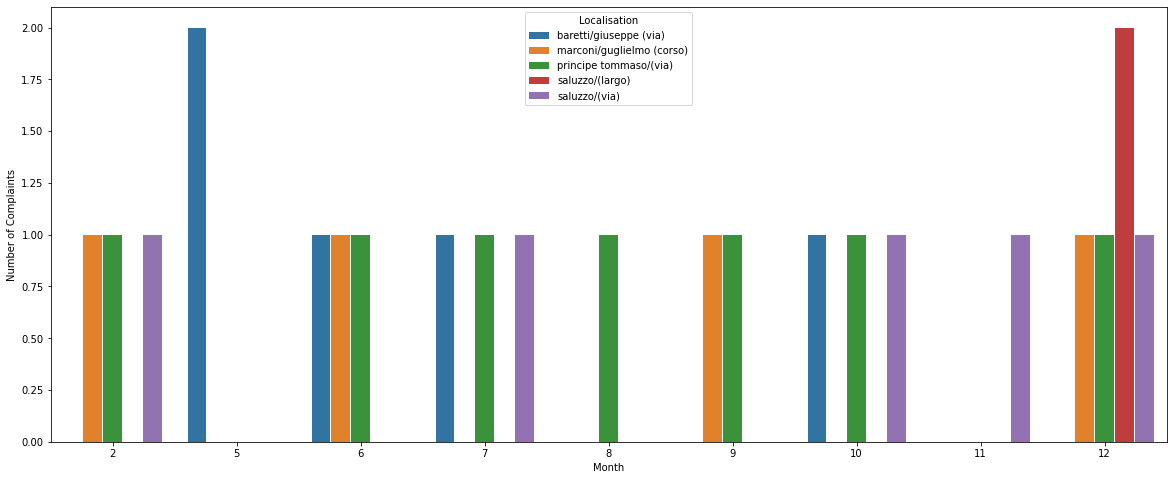

In [15]:
# Get the Month of the Complaints
df_filtered_san_salvario['Month'] = pd.DatetimeIndex(df_filtered_san_salvario['Timestamp']).month

# We add a new column with "1" to sum these complaints per month
df_filtered_san_salvario['Number of Complaints'] = 1

# Sum and group by Localisation and Month
df_grouped_san_salvario = df_filtered_san_salvario.groupby(['Localization', 'Month']).sum().reset_index()
df_grouped_san_salvario = df_grouped_san_salvario.copy()[["Localization", "Month", "Number of Complaints"]]


# Create the Figure object to generate the plot
fig, ax = pylab.subplots(figsize=(20, 8))

# Generate the plot
sns.barplot(data=df_grouped_san_salvario, ax=ax, x="Month", y="Number of Complaints", hue="Localization")

# Resize and show the plot 
change_width(ax, .15)
pylab.legend(loc='upper center', title="Localisation")
pylab.show()

## Typical Sensor Behavior

Before delving into the modelling phase, we needed to understand the data. Hence, we generated plots that show the regular behaviour of the noise sensors for:

 - All days: between 00.00 am - 05.00 am (night), the noise levels gradually decrease. Then, they start to increase from 06.00 am to 11.00 am - 12.00 pm (working hours). During the rest of the day, the levels seem to stabilise. At the end of the day, we can observe a slight increase in these levels. 
 - Working days of the week: the behaviour is similar to what is described above, but we can observe that, during the working days of the week, the noise level is below the average level for all days.
 - Weekends: the behaviour is similar to what is described above, but we can observe that, during the weekends, the noise level is above the average level for all days.
 - Holidays: the behaviour is similar to what is described above. We can observe that, during the holidays, the noise level is slightly above the average level for all days, although less intense than at weekends.

In [16]:
# Helper Function: Function to extract date features from a dataframe
def get_date_features(df_resampled, date_col, suffix, holidays_list):
    """
    Function for getting date features from a datetime column, based on Pandas DataSeries predefined functions. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in holidays_list)
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

In [17]:
# Create a new dataframe with the new date features (please notice the use of the variable with the Italy's Holidays as a date feature)
df_noise = get_date_features(df_noise, date_col='Timestamp', suffix='now', holidays_list=it_holidays)

# Show the resulting dataframe
df_noise.head()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,wind,temperature,rain,wind_gust,day_now,hour_now,month_now,dayofweek_now,is_holiday_now,is_weekend_now
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
3,01-06-2016,00:00,C4,60.4,2016-01-06,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
4,01-06-2016,00:00,C5,60.2,2016-01-06,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0


In [18]:
# Helper Function: Get the noise sensor behaviour (regular) during different parts of the week/year (in the case of holidays)
def plot_sensor_behavior(time='regular'):
    if time == 'global':
        mask = df_noise.Sensor_ID == 'C1'
        plot_title = 'All days'
        
    elif time == 'holidays':
        mask = (df_noise.Sensor_ID == 'C1') & (df_noise.is_holiday_now == True)
        plot_title = 'during holidays'
        
    elif time == 'weekends':
        mask = (df_noise.Sensor_ID == 'C1') & (df_noise.is_weekend_now == True) 
        plot_title = 'during weekends'
        
    else: 
        mask = (df_noise.Sensor_ID == 'C1') & (df_noise.is_weekend_now == False) & (df_noise.is_holiday_now == False)
        plot_title = 'during working days of the week'
        
    
    avg_intensity_per_hour = df_noise[mask].groupby(df_noise.Timestamp.dt.hour)['Intensity'].apply(dbmean)
    
    
    return avg_intensity_per_hour, plot_title

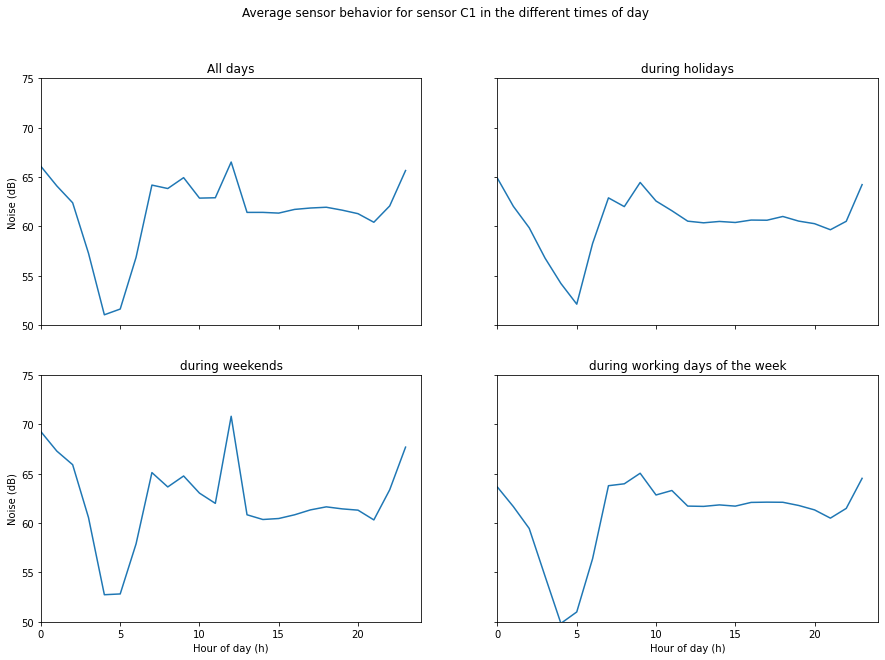

In [19]:
# Get dataframes for the four use cases explained above
avg_intensity_per_hour_global, title_global = plot_sensor_behavior('global')
avg_intensity_per_hour_holidays, title_holidays = plot_sensor_behavior('holidays')
avg_intensity_per_hour_weekends, title_weekends = plot_sensor_behavior('weekends')
avg_intensity_per_hour_regular, title_regular = plot_sensor_behavior('regular')

# Create the Figure object
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 10)

# Generate the Plots
fig.suptitle('Average sensor behavior for sensor C1 in the different times of day')
axs[0, 0].plot(np.arange(len(avg_intensity_per_hour_global)), avg_intensity_per_hour_global.values)
axs[0, 0].set_title(title_global)
axs[0, 1].plot(np.arange(len(avg_intensity_per_hour_holidays)), avg_intensity_per_hour_holidays.values)
axs[0, 1].set_title(title_holidays)
axs[1, 0].plot(np.arange(len(avg_intensity_per_hour_weekends)), avg_intensity_per_hour_weekends.values)
axs[1, 0].set_title(title_weekends)
axs[1, 1].plot(np.arange(len(avg_intensity_per_hour_regular)), avg_intensity_per_hour_regular.values)
axs[1, 1].set_title(title_regular)

# Apply several definitions for the plots
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 24)
custom_ylim = (50, 75)

# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
for ax in axs.flat:
    ax.set(xlabel='Hour of day (h)', ylabel='Noise (dB)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Feature Extraction and Target Creation

In [20]:
# Let's recall the noise dataframe again
df_noise.head()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,wind,temperature,rain,wind_gust,day_now,hour_now,month_now,dayofweek_now,is_holiday_now,is_weekend_now
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
3,01-06-2016,00:00,C4,60.4,2016-01-06,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
4,01-06-2016,00:00,C5,60.2,2016-01-06,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0


Extract noise-related features:
- Threshold: Does the current noise level exceed the limit (at day or night?)
- Relative difference between intensity and current maximum intensity

In [21]:
# Helper Function:  Get the current legal limit in each timestamp
def current_db(data, date_col='hour_now'):
    
    """
    Function for determining the current legal limit
    """
    
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) 
    mask_night = (data[date_col] > 22) | (data[date_col] < 6)
    mask = mask_day | mask_night
    data['current_max_db_value'] = np.where(mask==mask_day, data['day_max_db'], data['night_max_db'])
    
    
    return data



# Helper Function: Get the timestamps where noise exceeds threshold
def noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity'):
    
    """
    Function for determining if noise exceeds legal threshold
    """
    
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) & (data[value_col] > data['day_max_db'])
    mask_night = ((data[date_col] > 22) | (data[date_col] < 6)) & (data[value_col] > data['night_max_db'])
    mask = mask_day | mask_night

    data[f'noise_exceeds_threshold_{suffix}'] = np.where(mask, 1, 0)
    
    
    return data

In [22]:
# Relative difference between intensity and current maximum intensity
df_noise = current_db(df_noise, date_col='hour_now')
df_noise['relative_diff_intensity_max_db'] = (df_noise.Intensity - df_noise.current_max_db_value) / df_noise.Intensity

# Threshold: Does the current noise level exceed the limit (at day or night?)
df_noise = noise_threshold(df_noise, date_col='hour_now', suffix='now', value_col='Intensity')

# Show this dataframe
df_noise[['Timestamp', 'Intensity', 'noise_exceeds_threshold_now', 'current_max_db_value']].tail()

,Timestamp,Intensity,noise_exceeds_threshold_now,current_max_db_value
157075,2019-12-31 23:00:00,60.5,1,55
157076,2019-12-31 23:00:00,63.2,1,50
157077,2019-12-31 23:00:00,65.8,1,50
157078,2019-12-31 23:00:00,NaN,0,55
157079,2019-12-31 23:00:00,NaN,0,50


## Target Creation

In [23]:
# Helper Function: Function to create our targets based on noise levels
def create_target_noise_level(df_resampled, date_col = 'Timestamp', target_col = 'Intensity', entity_id='Sensor_ID', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled[f'date_col_{target_col}'] = df_resampled[date_col] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]].merge(
        df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]], 
        left_on = [entity_id, f'date_col_{target_col}'], 
        right_on=[entity_id, date_col], 
        how='left'
    )

    tmp = tmp[[entity_id, f'{date_col}_x', f'{target_col}_y']]
    tmp.columns = [entity_id, date_col, f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=[entity_id, date_col])
    
    return df_resampled

In [24]:
# Create our target
df_noise = create_target_noise_level(df_noise, target_col='Intensity', date_offset=24)

# Add date features on target date
# Add noise threshold on the hour of the target
df_noise = get_date_features(df_noise, date_col='date_col_Intensity', suffix='target', holidays_list=it_holidays)
df_noise = noise_threshold(df_noise, date_col='hour_target', suffix='target', value_col='target_Intensity_24h')

# Show this dataframe
df_noise.tail()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,noise_exceeds_threshold_now,date_col_Intensity,target_Intensity_24h,day_target,hour_target,month_target,dayofweek_target,is_holiday_target,is_weekend_target,noise_exceeds_threshold_target
157075,31-12-2019,23:00,C1,60.5,2019-12-31 23:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,1,2020-01-01 23:00:00,NaN,1,23,1,2,True,0,0
157076,31-12-2019,23:00,C2,63.2,2019-12-31 23:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,2020-01-01 23:00:00,NaN,1,23,1,2,True,0,0
157077,31-12-2019,23:00,C3,65.8,2019-12-31 23:00:00,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,1,2020-01-01 23:00:00,NaN,1,23,1,2,True,0,0
157078,31-12-2019,23:00,C4,NaN,2019-12-31 23:00:00,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,...,0,2020-01-01 23:00:00,NaN,1,23,1,2,True,0,0
157079,31-12-2019,23:00,C5,NaN,2019-12-31 23:00:00,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,...,0,2020-01-01 23:00:00,NaN,1,23,1,2,True,0,0


In [25]:
# Check target distribution when it's day and night (in this case we want to see if noise exceeds the legal threshold value)
# Day
mask_day = (df_noise['hour_now'] > 6) & (df_noise['hour_now'] < 22)
df_noise_day = df_noise[mask_day]
df_noise_day['noise_exceeds_threshold_target'].mean()

0.3482047364400306

In [26]:
# Night
mask_night = (df_noise['hour_now'] > 22) | (df_noise['hour_now'] < 6)
df_noise_night = df_noise[mask_night]
df_noise_night['noise_exceeds_threshold_target'].mean()

0.5900032740368875

In [27]:
# Let's recall the noise dataframe again
df_noise.head()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,noise_exceeds_threshold_now,date_col_Intensity,target_Intensity_24h,day_target,hour_target,month_target,dayofweek_target,is_holiday_target,is_weekend_target,noise_exceeds_threshold_target
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
3,01-06-2016,00:00,C4,60.4,2016-01-06,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
4,01-06-2016,00:00,C5,60.2,2016-01-06,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0


We will now create our target for complaints, following this rule:

- A complaint happened on day 24 (for instance). As some of the rows don't have the complaint date - and we don't know if the complaint date refers to the reporting date or the date of occurence - we consider that the noise could have happened on the 24 or 23.
- As we are predicting one day in advance, we consider as positive labels both 23 and 22. 

In [28]:
# We show you an example of a single Timestamp, for you to gain intuition
df_filtered_san_salvario[
    df_filtered_san_salvario.Timestamp == '2017-06-19'
]

,Criminal category,Criminal sub-category,District,Localization,Green Area,Date,Hour,Timestamp,address,Month,Number of Complaints
689,Civil coexistence,Disturbing noises,8.0,baretti/giuseppe (via),NaN,19/06/2017,NaN,2017-06-19,Via Principe Tommaso angolo via Baretti Torino,6,1


In [29]:
# Helper Function: Function to create the target based on complaints
def create_target_complaints(df_filtered_san_salvario, range_days = 2, target_forecast = 1):
    
    """
    Creates target for complaints
    """
    
    df_filtered_san_salvario['Date'] = pd.to_datetime(df_filtered_san_salvario['Date'])
    complaints = df_filtered_san_salvario[['Date', 'address']].drop_duplicates()

    # Target dates: same day or subtract one day (by default)
    range_deltas = [pd.Timedelta(x + 1, 'd') for x in np.arange(0, range_days)]

    target_dfs = []
    for x in range_deltas:
        complaints_copy = complaints.copy()
        complaints_copy['target_date'] = complaints_copy['Date'] - x

        target_dfs.append(complaints_copy)

    target_df_final = pd.concat(target_dfs)
    target_df_final['complaint_followed'] = 1
    target_df_final = target_df_final.rename(columns={'Date': 'complaint_date'})
    
    
    return target_df_final

In [30]:
# Create a new column that will be useful to performe a merging operation later
df_noise['Timestamp_trunc'] = df_noise['Timestamp'].dt.floor('d')

# Get the complaints list using the function above
complaints_list = create_target_complaints(df_filtered_san_salvario, range_days=1)

In [31]:
# Let's see and example for a specific date
complaints_list[complaints_list.complaint_date == '2017-06-19']

,complaint_date,address,target_date,complaint_followed
689,2017-06-19,Via Principe Tommaso angolo via Baretti Torino,2017-06-18,1


In [32]:
# Now let's merge the two dataframes on the new column previously added
df_noise = df_noise.merge(complaints_list, left_on=['Timestamp_trunc', 'address'], right_on=['target_date', 'address'], how='left')

In [33]:
# Add our target to the noise measurements dataframe
df_noise['complaint_followed'] = df_noise['complaint_followed'].fillna(0).astype(int)

In [34]:
# Let's see cases of complaints
df_noise[df_noise.complaint_followed == 1].head()

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,hour_target,month_target,dayofweek_target,is_holiday_target,is_weekend_target,noise_exceeds_threshold_target,Timestamp_trunc,complaint_date,target_date,complaint_followed
1801,16-06-2016,00:00,C2,58.2,2016-06-16 00:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,0,6,4,False,0,1,2016-06-16,2016-06-17,2016-06-16,1
1806,16-06-2016,01:00,C2,56.3,2016-06-16 01:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,6,4,False,0,1,2016-06-16,2016-06-17,2016-06-16,1
1811,16-06-2016,02:00,C2,54.5,2016-06-16 02:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,2,6,4,False,0,1,2016-06-16,2016-06-17,2016-06-16,1
1816,16-06-2016,03:00,C2,52.6,2016-06-16 03:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,3,6,4,False,0,0,2016-06-16,2016-06-17,2016-06-16,1
1821,16-06-2016,04:00,C2,47.1,2016-06-16 04:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,4,6,4,False,0,0,2016-06-16,2016-06-17,2016-06-16,1


In [35]:
# Helper Function: Calculate the Past Number of Complaints per area
def calculate_past_number_of_complaints_per_area(df_filtered_san_salvario, data):

    n_complaints_timestamp = df_filtered_san_salvario.merge(data, on=['address'])

    n_complaints_timestamp['Timestamp_x'] = pd.to_datetime(n_complaints_timestamp['Timestamp_x'])
    n_complaints_timestamp['Timestamp_y'] = pd.to_datetime(n_complaints_timestamp['Timestamp_y'])

    indexNames = n_complaints_timestamp[n_complaints_timestamp['Timestamp_x'] > n_complaints_timestamp['Timestamp_y']].index
    n_complaints_timestamp.drop(indexNames , inplace=True)

    n_complaints_timestamp=n_complaints_timestamp.groupby(['Sensor_ID', 'Timestamp_y']).size().reset_index(name='number_complaints_past').rename(columns={'Timestamp_y': 'Timestamp'})
    n_complaints_timestamp['number_complaints_past'] =  n_complaints_timestamp['number_complaints_past'] - 1
    data = n_complaints_timestamp.merge(data, on=['Sensor_ID', 'Timestamp'])
    
    return data

In [ ]:
# FIXME - validate if this is ok
df_noise = calculate_past_number_of_complaints_per_area(df_filtered_san_salvario, df_noise)
df_noise

# Model Training

In [ ]:
# We create a list of columns that we do not need to train our model
COLS_TO_REMOVE = [
    'Timestamp',
    'Sensor_ID',
    'address',
    'Lat',
    'Long',
    'area_type',
    'target_Intensity_24h',
    'date_col_Intensity',
    'noise_exceeds_threshold_target',
    'Timestamp_trunc',
    'complaint_followed',
    'code',
    'streaming',
    'target_date',
    'complaint_date',
    'Date',
    'Time',
    'number_complaints_past' ########## FIXME
    #'average_intensity_next_3h',
    #'noise_exceeds_threshold_target_2'
]

# Based on the previous list, we create a new list with the features that we actually need!
COLS_TO_KEEP = [x for x in df_noise.columns if x not in COLS_TO_REMOVE]

In [ ]:
COLS_TO_KEEP

In [ ]:
"""
# Cross validation for hyperparameter tuning

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor()

params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)]
}

search = RandomizedSearchCV(xgb, params, cv=tscv, n_iter=10, random_state=42)

search.fit(
    X_train[COLS_TO_KEEP].fillna(9999).astype(float), 
    y_train
)
"""

In [ ]:
df_noise = df_noise.sort_values(by= ['Timestamp', 'Sensor_ID']).reset_index(drop=True)

In [ ]:
df_noise_train = df_noise[~df_noise['target_Intensity_24h'].isna()]

In [ ]:
# TODO: Erase uppon review
"""
import random
np.random.seed(42)

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV

def train(df_noise, label_col = 'noise_exceeds_threshold_target', n_estimators=100, cols_to_keep=COLS_TO_KEEP, calibrate_probabilities=True):

    # Train model
    # Please note that we use 70% of the data set as our train set!
    X_train = df_noise[0:int(0.7*len(df_noise))]

    # We use the remaining 30% as test set
    X_test = df_noise[1 + int(0.7*len(df_noise)):]
    
    print("Training/test period", X_train.Timestamp.max(), " | ", X_test.Timestamp.min())

    # Our labels column
    y_train = X_train['noise_exceeds_threshold_target']
    
    # We train an XGBoost Regressor. 
    # Since it is a decision tree, it becomes easier to explain the decisions of our model
    xgb = XGBClassifier(n_estimators=n_estimators)

    if calibrate_probabilities:
        print("Running calibrated classifier")
        timeseries_split = TimeSeriesSplit(n_splits=3)
        xgb = CalibratedClassifierCV(xgb, cv=timeseries_split)

    # We train our model
    xgb.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), X_train[label_col])

    y_pred = xgb.predict_proba(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
    X_test['pred_score_noise'] = y_pred[:, 1]
    
    return xgb, X_test, y_pred
"""

In [ ]:
def train(df_noise, label_col = 'noise_exceeds_threshold_target', n_estimators=100, cols_to_keep=COLS_TO_KEEP, calibrate_probabilities=True, grid_search=True):

    # Train model
    # Please note that we use 70% of the data set as our train set!
    X_train = df_noise[0:int(0.7*len(df_noise))]

    # We use the remaining 30% as test set
    X_test = df_noise[1 + int(0.7*len(df_noise)):]
    
    print("Training/test period", X_train.Timestamp.max(), " | ", X_test.Timestamp.min())

    # Our labels column
    y_train = X_train['noise_exceeds_threshold_target']
    
    if grid_search:
        tscv = TimeSeriesSplit(n_splits=5)
        xgb = XGBClassifier()
        params = {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': range(3, 10, 2),
            'min_child_weight': range(1,6,2),
            'gamma': [i/10.0 for i in range(0,5)]
        }

        search = RandomizedSearchCV(xgb, params, cv=tscv, n_iter=10, random_state=42)

        search.fit(
            X_train[COLS_TO_KEEP].fillna(9999).astype(float), 
            y_train
        )
        xgb = search.best_estimator_
    
    else:
        # We train an XGBoost Regressor. 
        # Since it is a decision tree, it becomes easier to explain the decisions of our model
        xgb = XGBClassifier(n_estimators=n_estimators)

    if calibrate_probabilities:
        print("Running calibrated classifier")
        timeseries_split = TimeSeriesSplit(n_splits=3)
        xgb = CalibratedClassifierCV(xgb, cv=timeseries_split)

    # We train our model
    xgb.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), X_train[label_col])

    y_pred = xgb.predict_proba(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
    X_test['pred_score_noise'] = y_pred[:, 1]
    
    return xgb, X_test, y_pred

In [ ]:
# Compare calibrated and uncalibrated classifier

xgb_noise_calibrated, X_test_noise, y_pred_calibrated_noise = train(df_noise_train, label_col='noise_exceeds_threshold_target', calibrate_probabilities=True)

In [ ]:
xgb_noise_uncalibrated, X_test_noise, y_pred_uncalibrated_noise = train(df_noise_train, label_col='noise_exceeds_threshold_target', calibrate_probabilities=False)

In [ ]:
y_pred_calibrated_noise[:, 1].mean(), y_pred_uncalibrated_noise[:, 1].mean()

In [ ]:
X_test_noise['noise_exceeds_threshold_target'].mean()

In [ ]:
print("ROC AUC Calibrated", roc_auc_score(X_test_noise['noise_exceeds_threshold_target'], y_pred_calibrated_noise[:, 1]))
print("ROC AUC Uncalibrated", roc_auc_score(X_test_noise['noise_exceeds_threshold_target'], y_pred_uncalibrated_noise[:, 1]))

In [ ]:
def shap_plot(xgb, X_test):

    # Shap explanation

    # We now explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
    explainer = shap.Explainer(xgb)
    shap_values = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

    # Let's get a nice plot with the shap values so you can have an intuition on the rationale behind the model learned by the XGBoost Regressor
    shap.plots.beeswarm(shap_values, max_display=15)

    return shap_values

# Calibration doesnt work with shap - library bug! however, it doesnt change the ft importance. 
shap_values_noise = shap_plot(xgb_noise_uncalibrated, X_test_noise)

In [ ]:
# Compare calibrated and uncalibrated classifier

xgb_complaint_calibrated, X_test_complaint, y_pred_calibrated_complaint = train(df_noise_train, label_col='complaint_followed', calibrate_probabilities=True, n_estimators=5)

In [ ]:
# Compare calibrated and uncalibrated classifier

xgb_complaint_uncalibrated, X_test_complaint, y_pred_uncalibrated_complaint = train(df_noise_train, label_col='complaint_followed', calibrate_probabilities=False, n_estimators=5)

In [ ]:
y_pred_calibrated_complaint[:, 1].mean(), y_pred_uncalibrated_complaint[:, 1].mean()

In [ ]:
print("ROC AUC Calibrated", roc_auc_score(X_test_complaint['complaint_followed'], y_pred_calibrated_complaint[:, 1]))
print("ROC AUC Uncalibrated", roc_auc_score(X_test_complaint['complaint_followed'], y_pred_uncalibrated_complaint[:, 1]))

In [ ]:
shap_values_complaint = shap_plot(xgb_complaint_uncalibrated, X_test_complaint)

## Decision Process

We will now explain the rationale behind the decision support system that integrates the machine learning models we trained.

We start by creating a dictionary that maps the name of the features into human-like explanations.

In [ ]:
# Create a dict mapping the features to its name written in a less technical way
mapping_dict = {
    'Intensity':'Measured intensity in dB, at current date:',
    'day_max_db':'Maximum value of noise in dB, during day:',
    'night_max_db':'Maximum value of noise in dB, during day:',
    'day_now':'Current day:',
    'hour_now':'Current hour:',
    'month_now':'Current month:',
    'dayofweek_now':'Current day of the week:',
    'quarter_now':'Current quarter of the year:',
    'is_holiday_now':'Is this a holiday?',
    'is_weekend_now':'Is this weekend?',
    'noise_exceeds_threshold_now':'Does the current noise exceed the threshold value at this moment?',
    'current_max_db_value':'Maximum value of noise in dB, at this moment:',
    'relative_diff':'Difference between the current maximum of noise and the measured intensity:',
    'day_target':'The target day of this prediction:',
    'hour_target':'The target hour of this prediction:',
    'month_target':'The target month of this prediction:',
    'dayofweek_target':'The target day of the week of this prediction',
    'quarter_target':'The target quarter of year of this prediction',
    'is_holiday_target':'Is the target day of this prediction, a holiday?',
    'is_weekend_target':'Is the target day of this prediction, a weekend?',
}

We created a function that allows us to perform this conversion directly. Moreover, it is prepared to receive feature names that are not available in the initial mapping dictionary and store the feature value anyway. This way, the user could then check what happened and update the dictionary with a suitable correspondence between a feature name and a human-like explanation.

In [ ]:
def generate_explanation(figure_data, mapping_dict):
    
    # Create a list to store the feature names that are not available in the dictionary
    feature_names_not_available = list()
    
    # Get features names
    feature_names = figure_data['featureNames']
    # print(feature_names)
    
    # Get feature values
    feature_values = list()
    
    # Go through the dictionary
    explanation = str()
    for key, value in figure_data['features'].items():
        
        # Get feature text
        feature_text = mapping_dict.get(feature_names[key], "Feature is not available in the mapping dictionary:")
        
        # If this feature name is not available in the mapping dictionary
        if feature_text == "Feature is not available in the mapping dictionary:":
            
            # Let's append it to a list that can be used afterwards to update the mapping dictionary
            feature_names_not_available.append(feature_names[key])
        
        
        # Get feature value    
        feature_value = value['value']
        
        
        # Generate human-like explanation
        explanation += f"{feature_text} {feature_value}; "
    
    
    return explanation, feature_names_not_available

### Noise Prediction Results

We start this process with the generation of SHAP figures that will store the information we need to explain the decisions of our model (i.e., the most informative features).

In [ ]:
# Initialise JavaScript (this allows us to create and store the features)
shap.initjs()

# Create an empty list to store the figures
figures = list()

# Let's iterate through the values of X_test_noise
for index in range(2):
    
    # Get the SHAP-figure related to the current index
    fig = shap.plots.force(shap_values_noise[X_test_noise[COLS_TO_KEEP].reset_index(drop=True).index[index]])
    
    # Append the SHAP-figure to our list
    figures.append(fig)

    
# This is a "sanity-check" print
print(f"There are {len(figures)} figures")

Let's look closely at an example figure:

In [ ]:
# An example figure (index: 0)
figures[0]

We now extract these data to a new list. Let's see the structure of these data (spoiler: it is a dictionary):

In [ ]:
# Let's append figures data in a new list
figures_data = [fig.data for fig in figures]

# Let's get an example of these data structures (index: 0)
figures_data[0]

Let's generate the explanations and get the feature names that are not in our mapping dictionary (yet!):

In [ ]:
# We create a list to append the explanations
explanations_noise = list()

# And a list to append the feature names that are available in our mapping dictionary (at the moment)
ft_names_not_avail = list()

# Loop through the figures_data
for fig_data in figures_data:
    
    # Get the explanation and the feature names that are not available
    exp, ft_names_un = generate_explanation(fig_data, mapping_dict)
    
    explanations_noise.append(exp)
    ft_names_not_avail += ft_names_un
    
# explanations_complaints
explanations_noise_df = pd.DataFrame(explanations_noise, columns=['Explanation of Noise'])
explanations_noise_df

In [ ]:
# TODO: Get Description here
print(list(dict.fromkeys(ft_names_not_avail)))

In [ ]:
# Example explanation value for the Noise (index: 0)
explanations_noise_df.loc[0]['Explanation of Noise']

### Complaint Prediction Results

In [ ]:
# Initialise JavaScript (this allows us to create and store the features)
shap.initjs()

# Create an empty list to store the figures
figures = list()

# Let's iterate through the values of X_test_comp
for index in range(len(X_test_comp)):
    
    # Get the SHAP-figure related to the current index
    fig = shap.plots.force(shap_complaint_values[X_test_comp[COLS_TO_KEEP].reset_index(drop=True).index[index]])
    
    # Append the SHAP-figure to our list
    figures.append(fig)


# This is a "sanity-check" print
print(f"There are {len(figures)} figures")

Let's look closely at an example figure:

In [ ]:
# An example figure (index: 0)
figures[0]

We now extract these data to a new list. Let's see the structure of these data (spoiler: it is a dictionary):

In [ ]:
# Let's append figures data in a new list
figures_data = [fig.data for fig in figures]

# Let's get an example of these data structures (index: 0)
figures_data[0]

Let's generate the explanations and get the feature names that are not in our mapping dictionary (yet!):

In [ ]:
# Loop through explanations
explanations_complaints = list()

# And a list to append the feature names that are available in our mapping dictionary (at the moment)
ft_names_not_avail = list()

for fig_data in figures_data:
    exp, ftn_unavail = generate_explanation(fig_data, mapping_dict)
    explanations_complaints.append(exp)
    
    ft_names_not_avail += ftn_unavail
    
# explanations_complaints
explanations_complaints_df = pd.DataFrame(explanations_complaints, columns=['Explanation of Complaint']).astype(str)
explanations_complaints_df

In [ ]:
# TODO: Get Description here
print(list(dict.fromkeys(ft_names_not_avail)))

In [ ]:
# Example explanation value for the Complaint (index: 0)
explanations_complaints_df.loc[0]['Explanation of Complaint']

# TODO: Insert explanation here

In [ ]:
# Let's generate the dataframe with the final results
final_results = X_test_noise.copy()[['Sensor_ID', 'Timestamp']]
final_results['Prediction Hour'] = final_results['Timestamp'] + timedelta(days=1)
final_results['Probability of Noise Above'] = X_test_noise['pred_score_noise']
final_results['Explanation for Noise'] = explanations_noise_df['Explanation of Noise']
final_results['Probability of Complaint'] = X_test_comp['pred_score_complaint']
final_results['Explanation of Complaint'] = explanations_complaints_df['Explanation of Complaint']

final_results

# TODO: Get Night Results Only

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

Sound is an important and valuable part of everyday life. But when sound becomes noise, it can negatively affect our mental and physical health. Compared to other types of pollution, people often overlook noise pollution as a health hazard. However, it can cause health problems ranging from stress, poor concentration, productivity losses in the workplace, communication difficulties and fatigue from lack of sleep, to more serious issues such as cardiovascular disease, cognitive impairment, tinnitus and hearing loss [1]. A study by the World Health Organization titled ‘Burden of disease from environmental noise’ found that at least one million healthy years of life are lost each year in Europe alone due to noise pollution [2]. The realities of modern life mean the noises created in the nightlife, are not going to suddenly fall silent. The sounds produced by people talking, laughing, singing, and cheering, and the noises generated from the impact of glassware, beverage machines, loudspeakers, and/or the instruments of live bands adversely influence the quality of life of nearby residents (see table 3) [3].
Therefore, it is crucial to recognize that noise pollution is a serious health concern worthy of our attention, and find realistic and sustainable ways to manage and reduce it.


In this challenge, we built a model capable of predicting the probability of noise levels exceeding the legal limit in the recreational nightlife of the San Salvatore neighbourhood in Turin. This model, which predicts for the next day (i.e., 24 hours later), is also explainable since the user can know the possible cause of the probability of noise exceeding the limit being high in the same area the next day. Therefore, the solution could be delivered in the form of an API that would return the fields we show, allow easy integration with the Turin Municipality services, and no external dependencies - it could be deployed in the cloud, for example.
This model can then be used by local police forces that are already frequently used and therefore have mounted processes of action in the city of Turin (see table 6) [3]. 

Thus, knowing that in a certain area the next day the probability of the noise level exceeding the limit is high and the cause, they can prepare in advance teams to visit the place and optimize patrols. This decision process would need to be aligned with the team, to understand the various trade-offs between deciding to patrol one location compared to others and the costs involved. This prediction model can then be adapted for longer time windows to assist urban planning. If you predict that an area will be too noisy in 4 years, you can consider changing the legislation. Another solution would be to predict for the summer seasons, when more people are on vacation and enjoying the nightlife, thus causing higher noise levels. In this case, awareness programs for the population could be prepared in advance.
We have also developed a second model to predict the volume of noise complaints for the day after the day of occurrence (or the reporting day, depending on what the day of complaint refers to). There are 23 noise complaints matching directly to the locations of the sensors, spread throughout three years of data. As the exact timestamp of the complaint is not known, the complaint is a weak label that can be matched to the noise occurring at all hours of the day - even if the noise levels are low, making the creation of a model very challenging.

[1] Jariwala, H. J., Syed, H. S., Pandya, M. J., & Gajera, Y. M. (2017). Noise Pollution & Human Health: A Review. Indoor Built Environ, 1-4. [2] World Health Organization. (2011). Burden of disease from environmental noise: Quantification of healthy life years lost in Europe. World Health Organization. Regional Office for Europe.

[2] World Health Organization. (2011). Burden of disease from environmental noise: Quantification of healthy life years lost in Europe. World Health Organization. Regional Office for Europe.

[3] Ottoz, E., Rizzi, L., & Nastasi, F. (2018). Recreational noise: Impact and costs for annoyed residents in Milan and Turin. Applied Acoustics, 133, 173-181.

Table 3 - Noise annoyance levels for different time slots (% for each annoyance level), from [3].

![Table3](https://github.com/TiagoFilipeSousaGoncalves/wdl-tech-moguls/blob/main/finals/figures/table3_annoyance_levels_noise.png?raw=true)

Table 6 - Adopted solution strategies (% in teh sample), from [3].

![Table6](https://github.com/TiagoFilipeSousaGoncalves/wdl-tech-moguls/blob/main/finals/figures/table6_adopted_strategies.png?raw=true)

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

#### What kind of data would we like to have?

- Historical Values for past intensity values at same time / on same week day
- Add regional events data (we only have holidays, currently) 

Future work regarding target:
- Predicting if the average noise exceeded the legal threshold in the next night could be an extra alternative for targeting. So far this can be done in the decision process, which is very flexible.

#### What kind of features would we add?
In the future, it would be interesting to calibrate the probabilities of the model. The calibration module allows you to better calibrate the probabilities of a given model and to add support for probability prediction. this way, the probabilities of noise volume exceeding the threshold obtained by the prediction model would be more intuitive to the user and easier to explain and relate to the urgency and necessity of the patrolling process and action of local police forces. another future work would be to adapt the prediction model for larger time windows, as mentioned in the 'Scalability and Impact'. Predicting whether the noise level will be so high that it will exceed the limit in an area in two years time or during the bathing season, for example, will allow different measures to be taken to help improve the quality of life of the people living in that area.

In order to develop a better performing complaint prediction model, it is crucial to have access to more complaint data, with hour-specific information. We truly believe that having complaint hour data would allow us to create a more accurate model that could be used and implemented to manage and reduce noise in San Salvario.